## Import necessary modules 

In [1]:
from pathlib import Path
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

## Load .tif files

In [2]:
DATA_DIR = Path('./data')
before = rasterio.open(DATA_DIR / 'sentinel2a-before.tif')
after = rasterio.open(DATA_DIR / 'sentinel2a-after.tif')

assert before.height == after.height
assert before.width == after.width

num_pixels = before.height * before.width

## Water index analysis

[EOS Data Analytics, Normalized Difference Water Index](https://eos.com/make-an-analysis/ndwi/)

[Information on Sentinel-2 MSI bands](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands)

$$NDWI={X_{green}-X_{NIR} \over X_{green}+X_{NIR}}$$
[Gao, B. NDWI—A normalized difference water index for remote sensing of vegetation liquid water from
space. Remote Sens. Environ. 1996, 58, 257–266](https://doi.org/10.1016/S0034-4257(96)00067-3)

[S. K., McFeeters (1996): The use of the Normalized Difference Water Index (NDWI) in the delineation of open water features. International Journal of Remote Sensing. Volume 17](https://doi.org/10.1080/01431169608948714)

$$MNDWI={X_{green}-X_{SWIR1} \over X_{green}+X_{SWIR1}}$$
[Xu, H. Modification of normalised difference water index (NDWI) to enhance open water features in remotely
sensed imagery. Int. J. Remote Sens. 2006, 27, 3025–303](https://doi.org/10.1080/01431160600589179)

[Xu, H. (2005): A Study on Information Extraction of Water Body with the Modified Normalized Difference Water Index (MNDWI). Journal of Remote Sensing. 9: 589-595.](https://www.semanticscholar.org/paper/A-Study-on-Information-Extraction-of-Water-Body-the-Han-qiu/179deeb7efba5aa1443724088f030a542dcdfad0)

In [3]:
def normalized_index(img: rasterio.io.DatasetReader, b1: int, b2: int) -> np.ndarray:
    b1_data = img.read(b1).astype(float)
    b2_data = img.read(b2).astype(float)
    return (b1_data - b2_data) / (b1_data + b2_data)

before_ndwi = normalized_index(before, 3, 4)
after_ndwi = normalized_index(after, 3, 4)
before_mndwi = normalized_index(before, 3, 11)
after_mndwi = normalized_index(after, 3, 11)

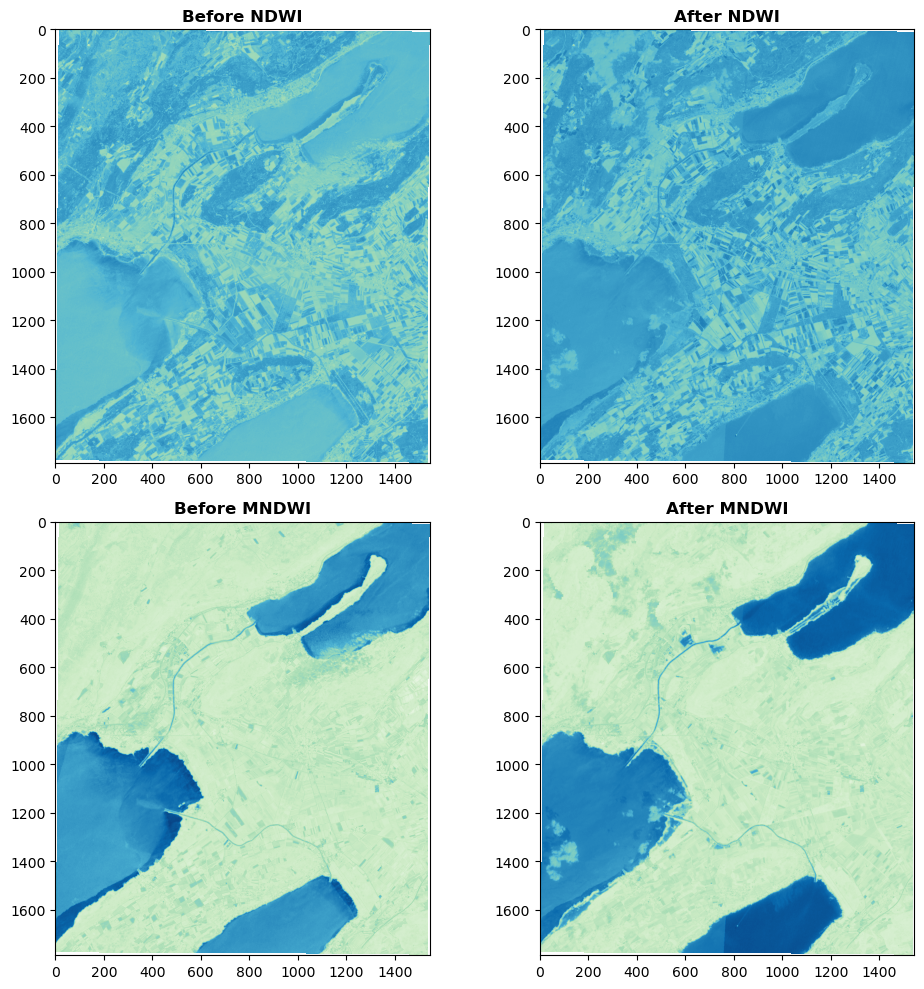

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
show(before_ndwi, ax=axs[0, 0], cmap='GnBu', title='Before NDWI')
show(after_ndwi, ax=axs[0, 1], cmap='GnBu', title='After NDWI')
show(before_mndwi, ax=axs[1, 0], cmap='GnBu', title='Before MNDWI')
show(after_mndwi, ax=axs[1, 1], cmap='GnBu', title='After MNDWI')
plt.tight_layout()
plt.show()

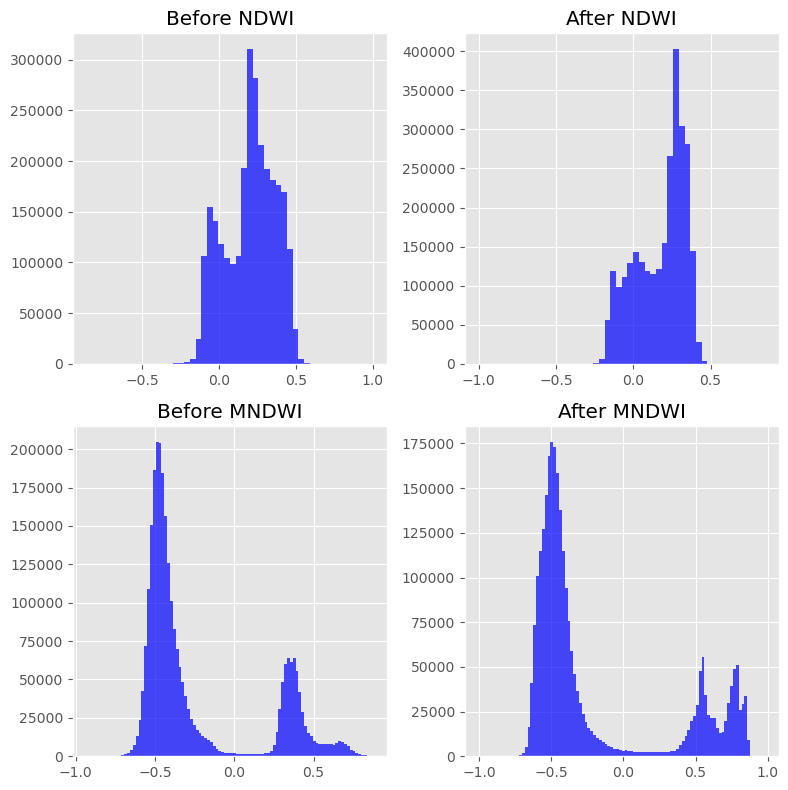

In [5]:
plt.style.use('ggplot')
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0, 0].hist(before_ndwi.flatten(), bins=50, color='blue', alpha=0.7)
axs[0, 0].set_title('Before NDWI')
axs[0, 1].hist(after_ndwi.flatten(), bins=50, color='blue', alpha=0.7)
axs[0, 1].set_title('After NDWI')
axs[1, 0].hist(before_mndwi.flatten(), bins=100, color='blue', alpha=0.7)
axs[1, 0].set_title('Before MNDWI')
axs[1, 1].hist(after_mndwi.flatten(), bins=100, color='blue', alpha=0.7)
axs[1, 1].set_title('After MNDWI')
plt.tight_layout()
plt.show()

## Calculate flooded areas using a threshold

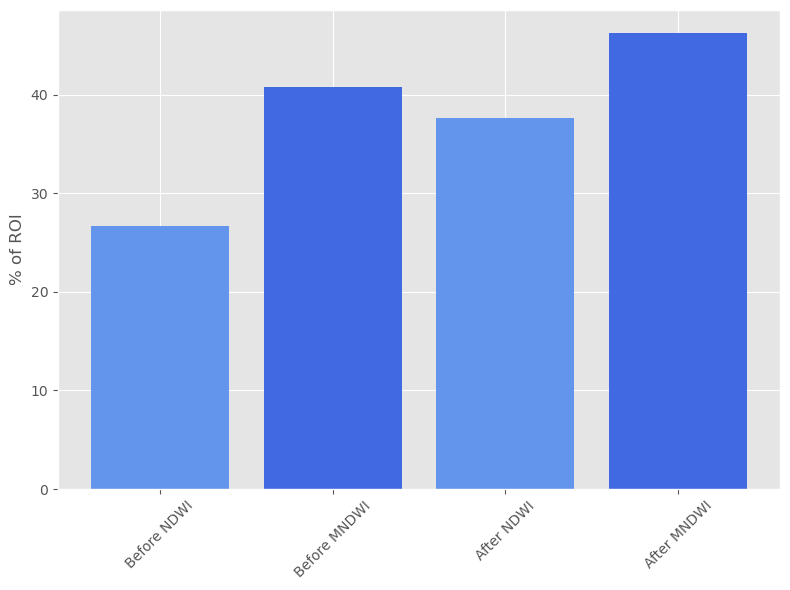

In [8]:
SPATIAL_RESOLUTION = 10

def calculate_flooded_area(index_image: np.ndarray, *, threshold: float) -> float:
    flooded_pixels = index_image < threshold
    return flooded_pixels.sum() * (SPATIAL_RESOLUTION ** 2)

before_tot_ndwi = calculate_flooded_area(before_ndwi, threshold=0.1)
percentage_before_ndwi = before_tot_ndwi / num_pixels
after_tot_ndwi = calculate_flooded_area(after_ndwi, threshold=0.15)
percentage_after_ndwi = after_tot_ndwi / num_pixels

before_tot_mndwi = calculate_flooded_area(before_mndwi, threshold=-0.45)
percentage_before_mndwi = before_tot_mndwi / num_pixels
after_tot_mndwi = calculate_flooded_area(after_mndwi, threshold=-0.45)
percentage_after_mndwi = after_tot_mndwi / num_pixels

percentages = [percentage_before_ndwi, percentage_before_mndwi, percentage_after_ndwi, percentage_after_mndwi]
events = ['Before NDWI', 'Before MNDWI', 'After NDWI', 'After MNDWI']
plt.figure(figsize=(8, 6))
plt.bar(events, percentages, color=['cornflowerblue', 'royalblue', 'cornflowerblue', 'royalblue'])
plt.ylabel('% of ROI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()